1. Data initialization

In [165]:
import os
import pandas as pd
import numpy as np
from featurewiz import featurewiz
from matplotlib import pyplot as plt
import json


folder = os.path.join("/", "RanD", "CREMEv2_Result", "20230310", "logs_working", "label_traffic")

if os.path.exists(folder):
    print("Path is exist!!!")
    filename_label = 'label_traffic.csv'
    filename_ready = 'label_traffic_ready.csv'
    filename_train = 'label_traffic_train.csv'
    label_technique = 'labels_technique.json'
    label_lifecycle = 'labels_lifecycle.json'
else:
    print("Path is not exist!!!")

Path is exist!!!


2. Data processing and feature selection

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2355448 entries, 0 to 2355447
Data columns (total 59 columns):
 #   Column           Dtype  
---  ------           -----  
 0   StartTime        float64
 1   Sport            int64  
 2   Dport            int64  
 3   TotPkts          int64  
 4   TotBytes         int64  
 5   LastTime         float64
 6   Seq              int64  
 7   Dur              float64
 8   Mean             float64
 9   StdDev           float64
 10  Sum              float64
 11  Min              float64
 12  Max              float64
 13  SrcPkts          int64  
 14  DstPkts          int64  
 15  SrcBytes         int64  
 16  DstBytes         int64  
 17  Rate             float64
 18  SrcRate          float64
 19  DstRate          float64
 20  Label            int64  
 21  Label_lifecycle  int64  
 22  Flgs_ e          int64  
 23  Flgs_ e   t      int64  
 24  Flgs_ e *        int64  
 25  Flgs_ e d        int64  
 26  Flgs_ e d t      int64  
 27  Flgs_ e g   

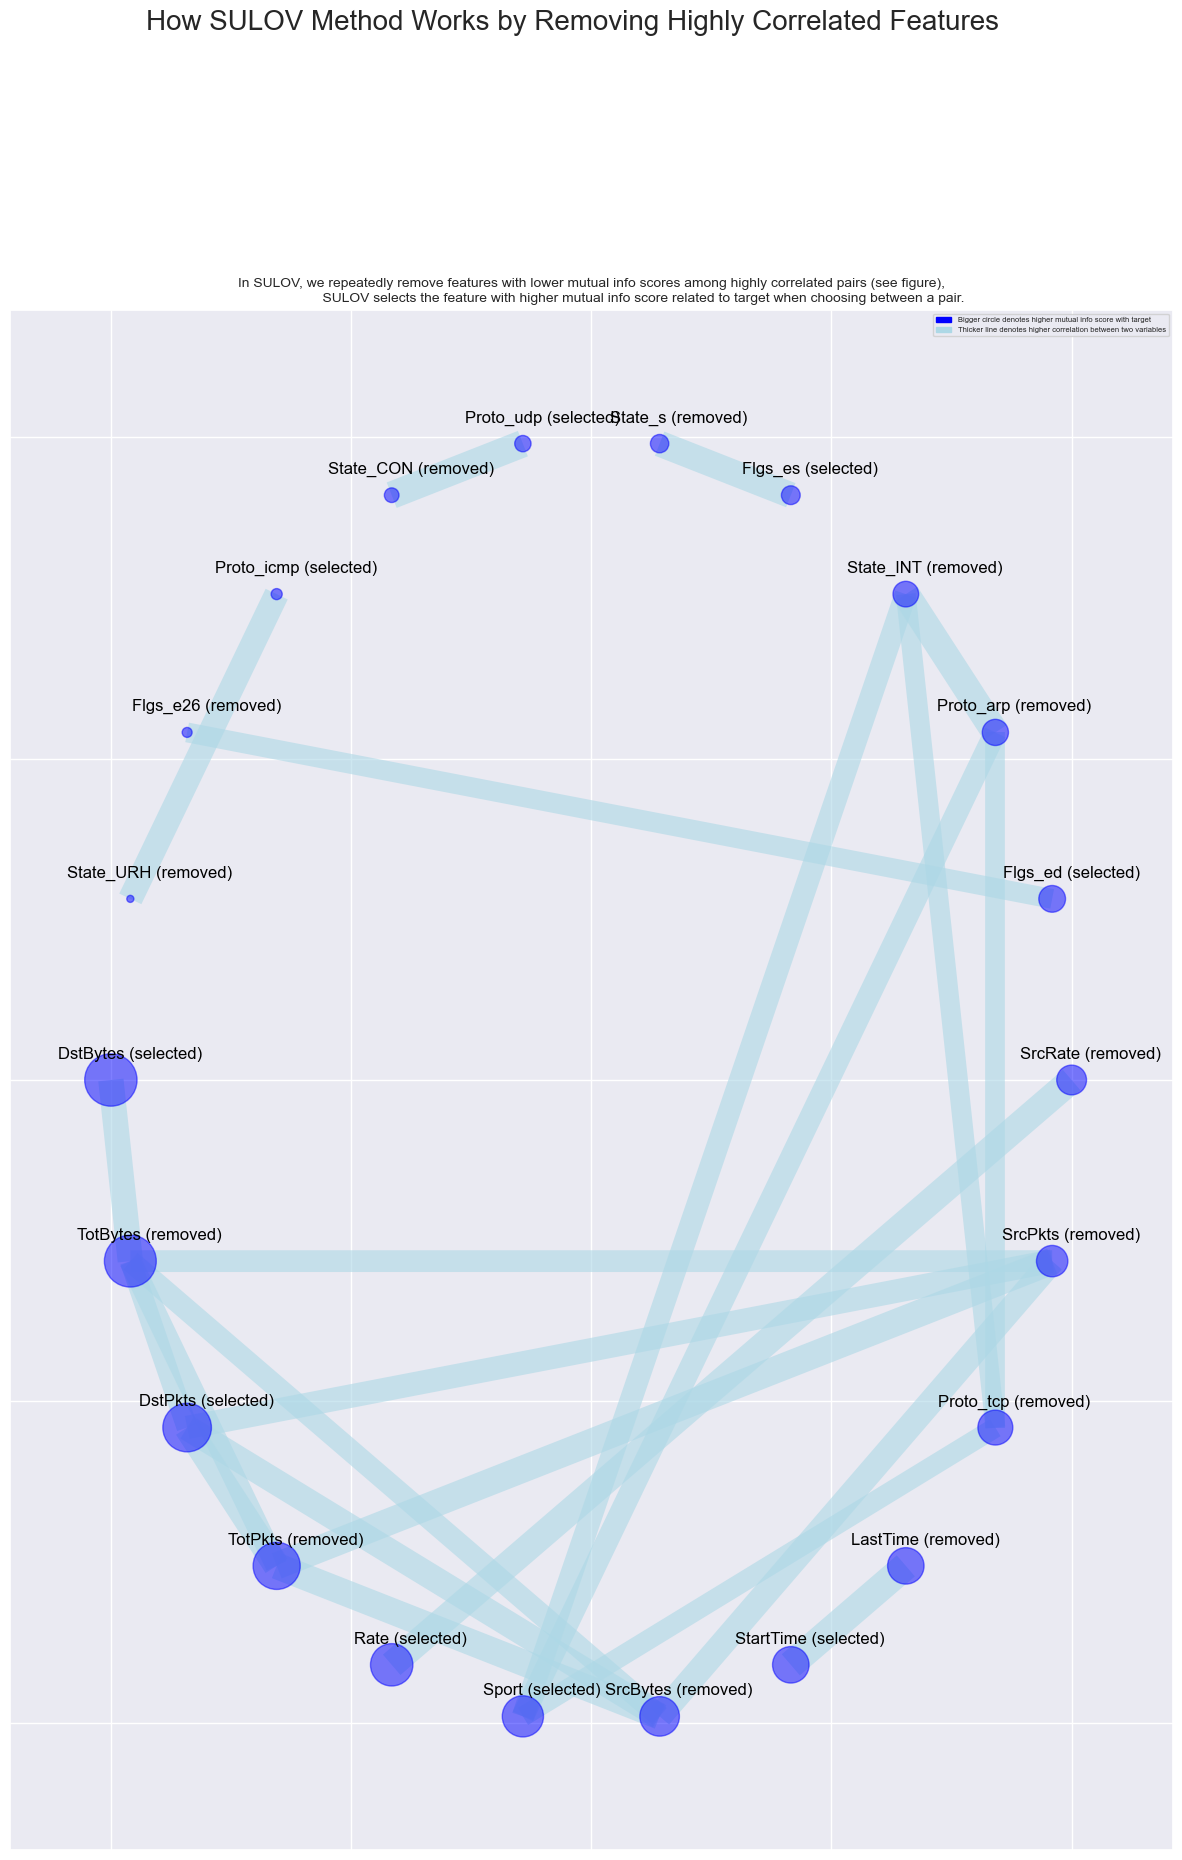

Time taken for SULOV method = 1 seconds
    Adding 0 categorical variables to reduced numeric variables  of 38
Finally 38 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 38 
    Taking top 7 features per iteration...
    XGBoost version using 1.7.4 as tree method: hist
Number of booster rounds = 20
        using 38 variables...
Regular XGBoost is crashing due to: [15:12:26] ../src/objective/multiclass_obj.cu:123: SoftmaxMultiClassObj: label must be in [0, num_class).
Stack trace:
  [bt] (0) /opt/anaconda3/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x670129) [0x7f2e53cc8129]
  [bt] (1) /opt/ana

In [166]:
fields_with_hex_value = ['Sport', 'Dport']
replace_strings = dict()
remove_rows_with_str = dict()

df = pd.read_csv(os.path.join(folder, filename_label), low_memory=False)


# one-hot encoding
# data = pd.get_dummies(data, columns=one_hot_col_list)

# # string replacement
for old_value, new_value in replace_strings.items():
    df = df.replace(to_replace=old_value, value=new_value, regex=True)
for old_value, new_value in remove_rows_with_str.items():
    df = df.replace(to_replace=old_value, value=new_value)

# preprocess hex value, str -> int
for field in fields_with_hex_value:
    df[field] = df[field].fillna(-1)
    df[field] = df[field].apply(lambda x: x if type(x) is str else int(x))
    df[field] = df[field].apply(lambda x: int(x, 0) if type(x) is str and x[:2] == "0x" else x)
    # df[field] = df[field].apply(lambda x: int(str(x), 0))
    df[field] = df[field].apply(lambda x: int(float(str(x))))


# column name cleaning
column_names = df.columns.values
for i in range(len(column_names)):
    column_names[i] = column_names[i].strip()
df.columns = column_names

df.info()

# removing unused features from dataset
target = "Label"

feature, train = featurewiz(df, target, corr_limit=0.7, verbose=2, sep=",", header=0, test_data="", feature_engg="", category_encoders="")
df = train
print(feature)
output_filename = os.path.join(folder, filename_ready)
df.to_csv(output_filename, encoding='UTF-8', index=False)


3. Training preparation

In [167]:

from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer

df = pd.read_csv(os.path.join(folder, filename_ready))

del_list = ['StartTime', 'Label_lifecycle']
max_threshold = 100000
min_threshold = 20

print("origin data number: {0}".format(len(df.index)))
print("origin features: {0}".format(len(df.columns)-1))

df.drop(columns=del_list, inplace=True)

for label in df['Label'].unique():
    # if too much, try drop duplicated first
    if len(df[df['Label'] == label]) > max_threshold:
        df_tmp = df.loc[df['Label'] == label].copy()
        df_tmp.drop_duplicates(keep='last', inplace=True)
        df.drop(df[df['Label'] == label].index, inplace=True)
        df = pd.concat([df, df_tmp])
        
    # if still too much, randomly picking some of them
    if len(df[df['Label'] == label]) > max_threshold:
        df_tmp = df.loc[df['Label'] == label].copy()
        df_tmp = df_tmp.sample(n=max_threshold, random_state=47)
        df.drop(df[df['Label'] == label].index, inplace=True)
        df = pd.concat([df, df_tmp])

    # if too few, double their number until it's enough
    while len(df[df['Label'] == label]) < min_threshold:
        tmp_df = df[df['Label'] == label]
        df = pd.concat([df, tmp_df])


# feature scaling
y_tmp = df['Label']
df.drop(columns=['Label'], inplace=True)
for feature in df.columns.values:
    scaler = StandardScaler().fit(df[feature].values.reshape(-1, 1))
    df[feature] = scaler.transform(df[feature].values.reshape(-1, 1))
df = pd.concat([df, y_tmp], axis=1)


print("remain data number: {0}".format(len(df.index)))
print("remain features: {0}".format(len(df.columns)-1))

output_file = os.path.join(folder, filename_train)
df.to_csv(output_file, encoding='utf-8', index=False)


origin data number: 2355448
origin features: 38
remain data number: 214426
remain features: 36


4. Training and testing

In [168]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import pickle
import time
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import math

models_folder = "model_traffic"

df = pd.read_csv(os.path.join(folder, filename_train))

#labelings map
label_origin = sorted([int(i) for i in df['Label'].unique()])
le = preprocessing.LabelEncoder()
le.fit(df['Label'])
le_origin_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
origin_le_mapping = dict(zip(le.transform(le.classes_), le.classes_))

X = df.drop(columns=['Label'])
X = X.to_numpy()
y = df['Label']
y = y.to_numpy()
y = y.reshape(-1)
y = le.transform(y)


#ML training
## Define ML model
core = -1

models = {}

### Linear models
models['Logistic_Regression'] = LogisticRegression(max_iter=1500, n_jobs=core)
models['SGD'] = SGDClassifier(n_jobs=core)
models['Passive_Aggressive'] = PassiveAggressiveClassifier(n_jobs=core)
### non-linear models
models['Decision_Tree'] = DecisionTreeClassifier()
models['Extra_Tree'] = ExtraTreeClassifier()
models['Naive_Bayes'] = GaussianNB()
### models['SVM'] = SVC(kernel='rbf', gamma='auto')
models['KNN'] = KNeighborsClassifier(n_jobs=core)
### ensemble models
models['Random_Forest'] = RandomForestClassifier(n_jobs=core)
### models['Ada_Boost'] = AdaBoostClassifier()
models['Bagging'] = BaggingClassifier(n_jobs=core)
models['Extra_Trees'] = ExtraTreesClassifier(n_jobs=core)
models['Gradient_Boosting'] = GradientBoostingClassifier()
models['XGBoost'] = XGBClassifier(objective='multi:softprob', eval_metric='merror', n_jobs=core)


random_seed = 42


## training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train, y_train = SMOTE(n_jobs=-1, random_state=random_seed).fit_resample(X_train, y_train)
print("original labels:{}".format(label_origin))
print("X_train:{}, y_train:{}".format(len(X_train), len(y_train)))


evaluation = {}
for name in models:
    evaluation[name] = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
        # 'roc_auc_score': []
    }

    
for name, model in models.items():
    start_time = time.time()
    model_filename = os.path.join(models_folder, name)
    if os.path.exists(model_filename): # load the model from disk
        model = pickle.load(open(model_filename, 'rb'))
    else:
        model.fit(X_train, y_train)
        pickle.dump(model, open(model_filename, 'wb')) # save the model to disk
    y_hat = model.predict(X_test)
    end_time = time.time()
    print("model: {} \nexecution time: {:.2f}\n".format(name, end_time - start_time))
    
    # evaluation
    evaluation[name]['accuracy'].append(accuracy_score(y_test, y_hat,))
    evaluation[name]['precision'].append(precision_score(y_test, y_hat, average='weighted',zero_division=0))
    evaluation[name]['recall'].append(recall_score(y_test, y_hat, average='weighted', zero_division=0))
    evaluation[name]['f1_score'].append(f1_score(y_test, y_hat, average='weighted', zero_division=0))
    # evaluation[name]['roc_auc_score'].append(roc_auc_score(y, model.predict_proba(X)[:,1], multi_class='ovr'))

KeyboardInterrupt: 

4.1 Visualization Bar

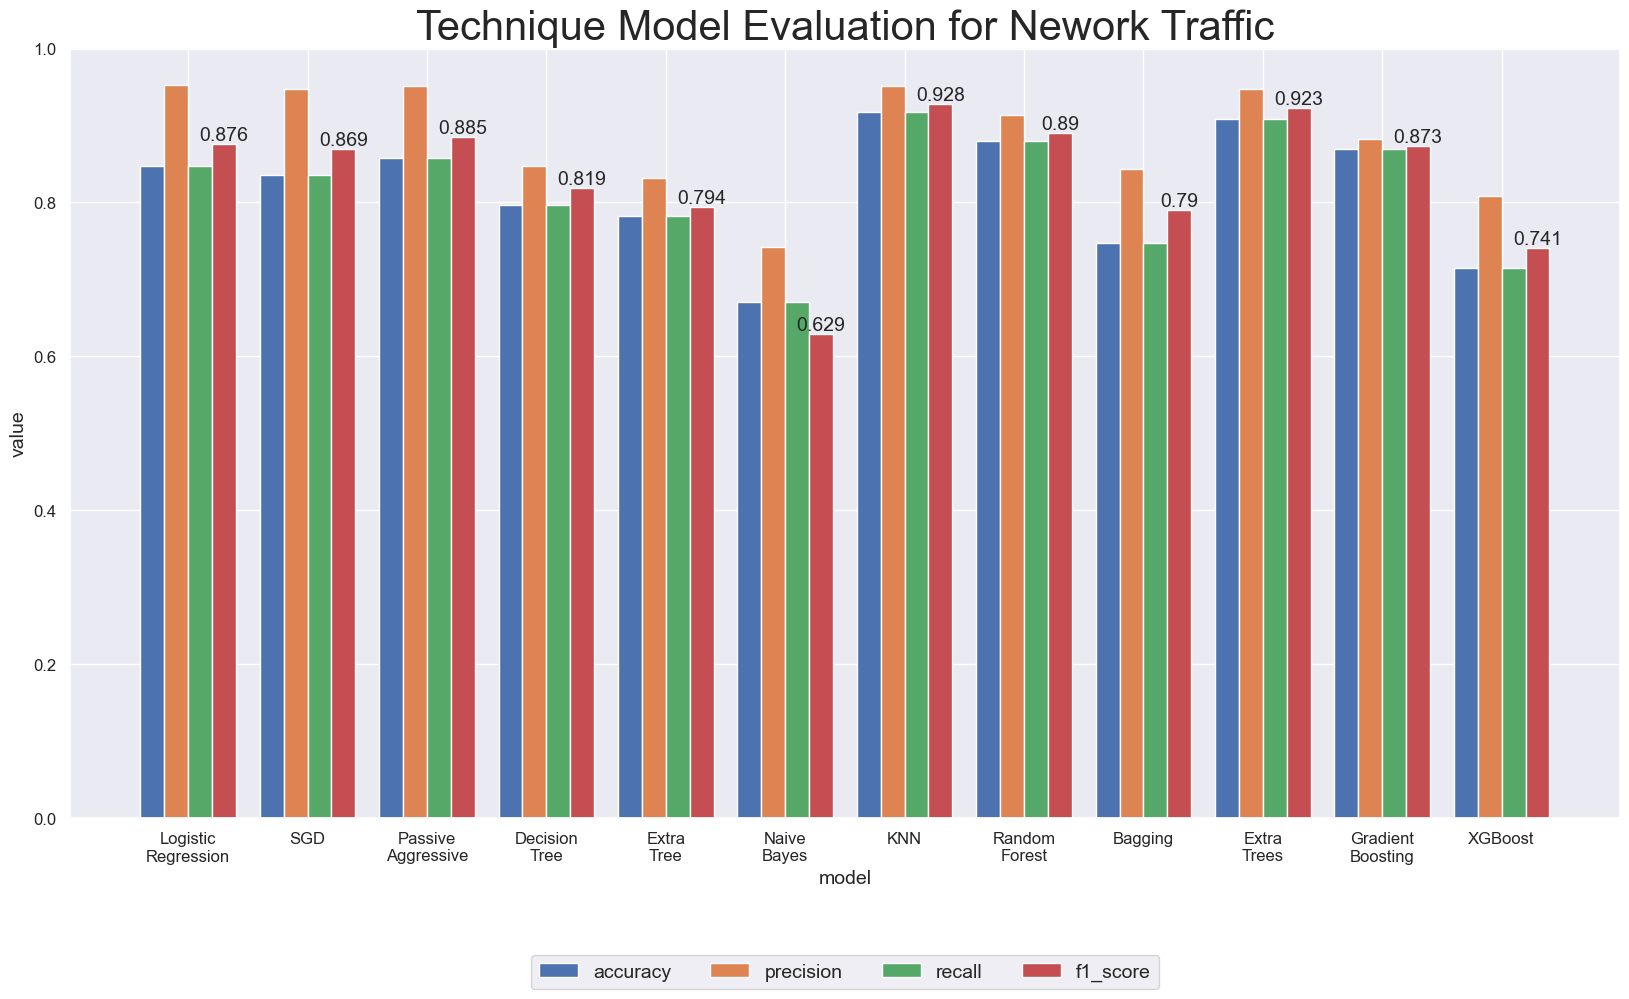

In [169]:
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import tree
import pickle

data_type = 'Nework Traffic'

def rounded(value, n):
    return math.floor(value * (10 ** n)) / float(10 ** n) 

models = [name.replace('_', '\n') for name in evaluation]
result = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}
for name in evaluation:
    for key, value in evaluation[name].items():
        result[key].append(rounded(mean(value), 3))
        
width = 0.2
x = np.arange(len(models))
plt.figure(figsize=(20, 10))
plt.bar(x, result['accuracy'], width, label='accuracy')
plt.bar(x+width, result['precision'], width, label='precision')
plt.bar(x+2*width, result['recall'], width, label='recall')
bar = plt.bar(x+3*width, result['f1_score'], width, label='f1_score')
plt.bar_label(bar, label_type='edge', fontsize=14)
plt.title('Technique Model Evaluation for '+data_type, fontsize=30)
plt.xticks(x+1.5*width, models)
plt.xlabel('model', fontsize=14)
plt.ylabel('value', fontsize=14)
plt.rcParams.update({
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
})
plt.legend(loc='center', fontsize=14, ncol=4, bbox_to_anchor=(0.5,-0.2))
plt.show()


4.2 Confusion Matrix

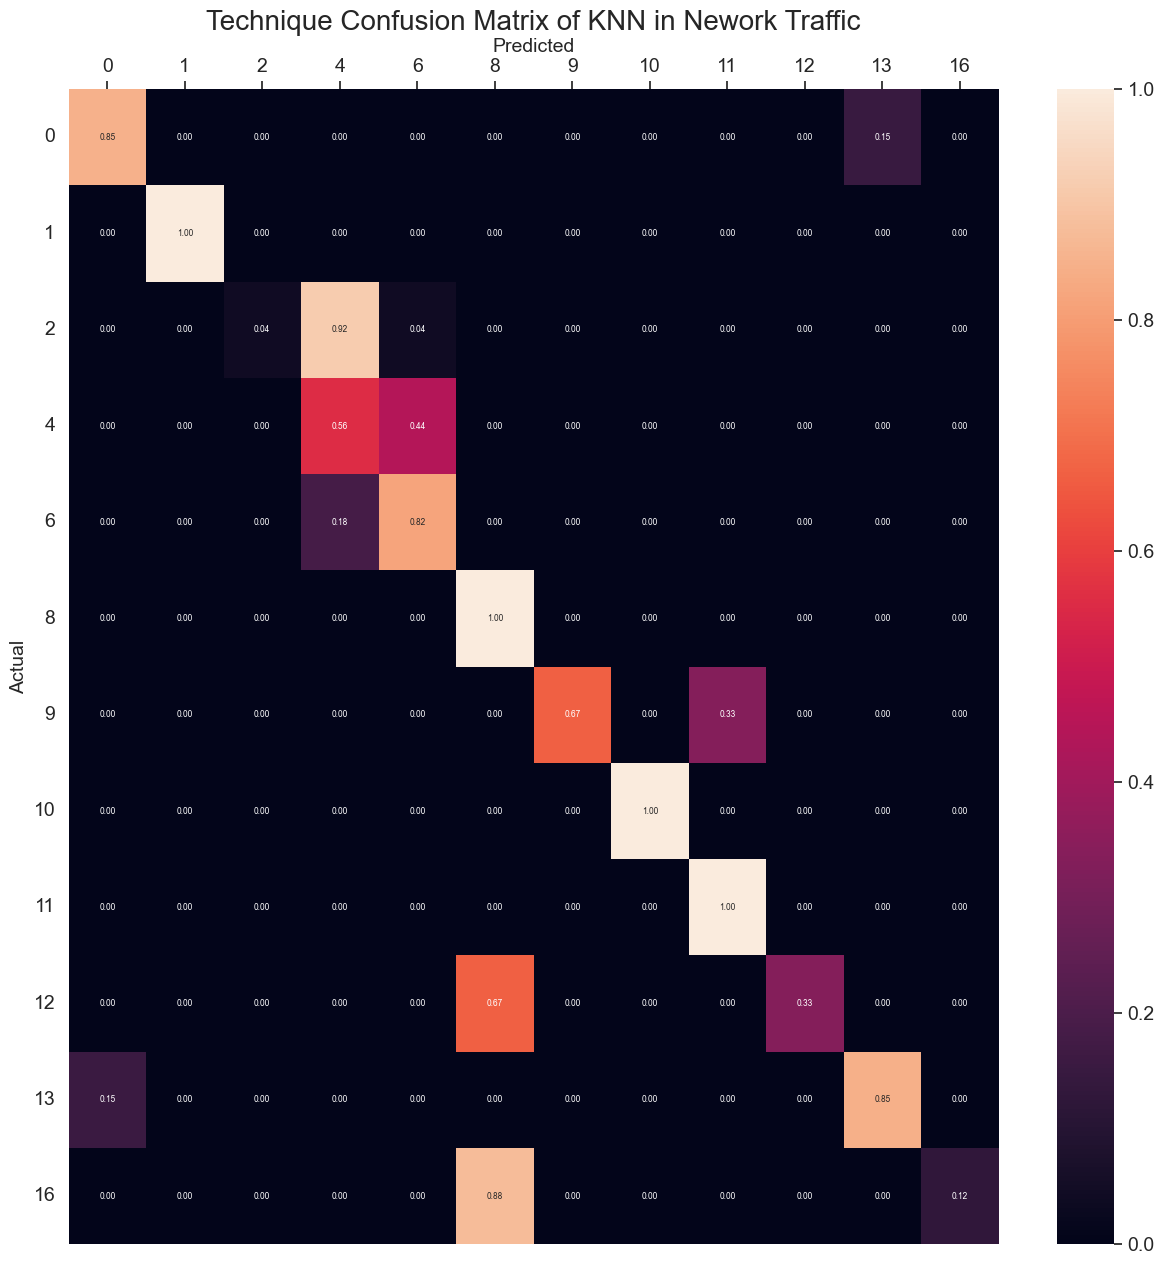

In [ ]:

name = 'KNN'
model_filename = os.path.join(models_folder, name)
title = "Technique Confusion Matrix of {} in {}".format(name, data_type)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
target_names = label_origin
# model = tf.keras.models.load_model(model_filename)
model = pickle.load(open(model_filename, 'rb'))
y_hat = model.predict(X_test)
# y_hat = np.argmax(y_hat, axis=1)

cm = confusion_matrix(y_test, y_hat)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.title(title, fontsize=20)
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show(block=False)

# tree.export_graphviz(model)

5. Training and Testing Macro

In [ ]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import pickle
import time
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import math

models_folder = "model_traffic_macro"

df = pd.read_csv(os.path.join(folder, filename_train))

#labelings map
label_origin = sorted([int(i) for i in df['Label'].unique()])
le = preprocessing.LabelEncoder()
le.fit(df['Label'])
le_origin_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
origin_le_mapping = dict(zip(le.transform(le.classes_), le.classes_))

X = df.drop(columns=['Label'])
X = X.to_numpy()
y = df['Label']
y = y.to_numpy()
y = y.reshape(-1)
y = le.transform(y)


#ML training
## Define ML model
core = -1

models = {}

### Linear models
models['Logistic_Regression'] = LogisticRegression(max_iter=1500, n_jobs=core)
models['SGD'] = SGDClassifier(n_jobs=core)
models['Passive_Aggressive'] = PassiveAggressiveClassifier(n_jobs=core)
### non-linear models
models['Decision_Tree'] = DecisionTreeClassifier()
models['Extra_Tree'] = ExtraTreeClassifier()
models['Naive_Bayes'] = GaussianNB()
### models['SVM'] = SVC(kernel='rbf', gamma='auto')
models['KNN'] = KNeighborsClassifier(n_jobs=core)
### ensemble models
models['Random_Forest'] = RandomForestClassifier(n_jobs=core)
### models['Ada_Boost'] = AdaBoostClassifier()
models['Bagging'] = BaggingClassifier(n_jobs=core)
models['Extra_Trees'] = ExtraTreesClassifier(n_jobs=core)
models['Gradient_Boosting'] = GradientBoostingClassifier()
models['XGBoost'] = XGBClassifier(objective='multi:softprob', eval_metric='merror', n_jobs=core)


random_seed = 42


## training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train, y_train = SMOTE(n_jobs=-1, random_state=random_seed).fit_resample(X_train, y_train)
print("original labels:{}".format(label_origin))
print("X_train:{}, y_train:{}".format(len(X_train), len(y_train)))


evaluation = {}
for name in models:
    evaluation[name] = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
        # 'roc_auc_score': []
    }

    
for name, model in models.items():
    start_time = time.time()
    model_filename = os.path.join(models_folder, name)
    if os.path.exists(model_filename): # load the model from disk
        model = pickle.load(open(model_filename, 'rb'))
    else:
        model.fit(X_train, y_train)
        pickle.dump(model, open(model_filename, 'wb')) # save the model to disk
    y_hat = model.predict(X_test)
    end_time = time.time()
    print("model: {} \nexecution time: {:.2f}\n".format(name, end_time - start_time))
    
    # evaluation
    evaluation[name]['accuracy'].append(accuracy_score(y_test, y_hat,))
    evaluation[name]['precision'].append(precision_score(y_test, y_hat, average='macro',zero_division=0))
    evaluation[name]['recall'].append(recall_score(y_test, y_hat, average='macro', zero_division=0))
    evaluation[name]['f1_score'].append(f1_score(y_test, y_hat, average='macro', zero_division=0))
    # evaluation[name]['roc_auc_score'].append(roc_auc_score(y, model.predict_proba(X)[:,1], multi_class='ovr'))

original labels:[0, 1, 2, 4, 6, 8, 9, 10, 11, 12, 13, 16]
X_train:482112, y_train:482112


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


model: Logistic_Regression 
execution time: 356.35

model: SGD 
execution time: 3.09

model: Passive_Aggressive 
execution time: 3.08

model: Decision_Tree 
execution time: 4.37

model: Extra_Tree 
execution time: 0.35

model: Naive_Bayes 
execution time: 0.24

model: KNN 
execution time: 203.40

model: Random_Forest 
execution time: 16.76

model: Bagging 
execution time: 7.33

model: Extra_Trees 
execution time: 19.57

model: Gradient_Boosting 
execution time: 1855.99

model: XGBoost 
execution time: 265.87



5.1 Visualization Bar

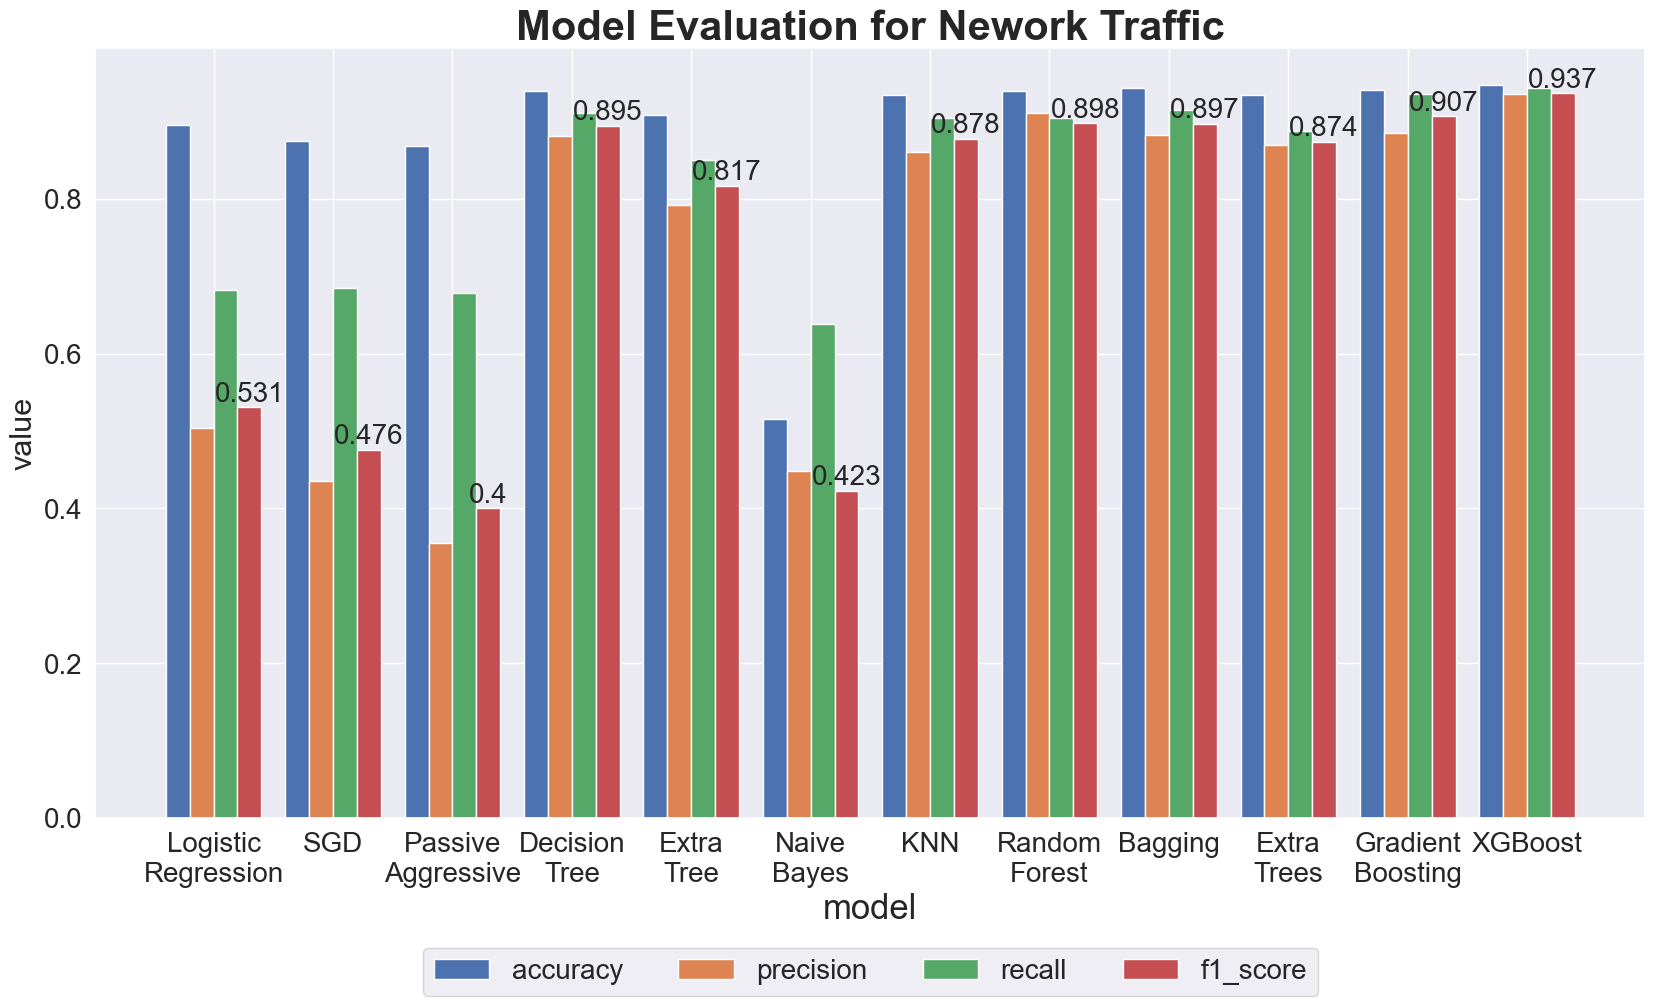

In [ ]:
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import tree
import pickle

data_type = 'Nework Traffic'

def rounded(value, n):
    return math.floor(value * (10 ** n)) / float(10 ** n) 

models = [name.replace('_', '\n') for name in evaluation]
result = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}
for name in evaluation:
    for key, value in evaluation[name].items():
        result[key].append(rounded(mean(value), 3))
        
width = 0.2
x = np.arange(len(models))
plt.figure(figsize=(20, 10))
plt.bar(x, result['accuracy'], width, label='accuracy')
plt.bar(x+width, result['precision'], width, label='precision')
plt.bar(x+2*width, result['recall'], width, label='recall')
bar = plt.bar(x+3*width, result['f1_score'], width, label='f1_score')
plt.bar_label(bar, label_type='edge', fontsize=20)
plt.title('Model Evaluation for '+data_type, fontsize=30, weight='bold')
plt.xticks(x+1.5*width, models)
plt.xlabel('model', fontsize=25)
plt.ylabel('value', fontsize=22)
plt.rcParams.update({
    'xtick.labelsize': 14,
    'ytick.labelsize': 20,
})
plt.legend(loc='center', fontsize=20, ncol=4, bbox_to_anchor=(0.5,-0.2))
plt.show()

5.1 Confusion Matrix

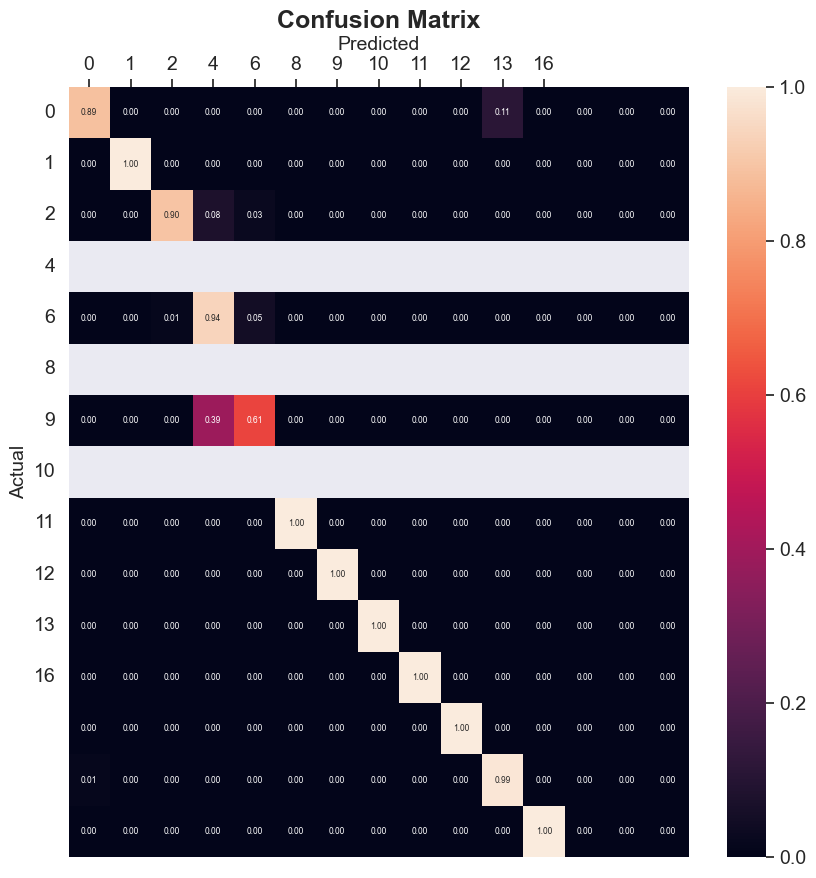

In [ ]:
name = 'XGBoost'
model_filename = os.path.join(models_folder, name)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
target_names = label_origin
# model = tf.keras.models.load_model(model_filename)
model = pickle.load(open(model_filename, 'rb'))
y_hat = model.predict(X_test)
# y_hat = np.argmax(y_hat, axis=1)

cm = confusion_matrix(y_test, y_hat)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.title('Confusion Matrix', fontsize=18, weight='bold')
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show(block=False)

# tree.export_graphviz(model)

5.3 AuC RoC